## This piece of code is an example in excessive memory allocation :(

In [1]:
import warnings

warnings.simplefilter('ignore')

In [2]:
import bisect
import collections
import random

import numpy as np
import tables

%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd

from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO  
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.svm import LinearSVC

from IPython.display import Image
import pydotplus as pydot

In [3]:
parents = [['AD0231-C', 'AD0232-C'], ['AD0254-C', 'AD0255-C'],
           ['AD0305-C', 'AD0306-C'], ['AD0347-C', 'AD0348-C']]

crosses_3L_h5 = '../raw/crosses-3L.h5'

In [4]:
def get_offspring_range(parents, all_parents, samples):
    my_index = samples.index(parents[1])
    start = my_index + 1
    parents_position = all_parents.index(parents)
    if  parents_position == len(all_parents) - 1:
        end = len(samples)
    else:
        end = samples.index(all_parents[parents_position + 1][0])
    return start, end

In [5]:
store_3L = tables.open_file(crosses_3L_h5, 'r')

In [6]:
samples = [x.decode('utf-8') for x in store_3L.get_node('/3L/samples').read()]

In [7]:
def compute_medelian_errors(parents, offspring):
    #autosome only
    mo_alleles = set(parents[0])
    fa_alleles = set(parents[1])
    if set([-1]) in [mo_alleles, fa_alleles]:
        return
    if len(mo_alleles) == 2 and len(fa_alleles) == 2:
        #Both HZ, this case it not trivial
        return
    cnt = cnt_mo = cnt_fa = total = 0
    for ofs in offspring:
        my_alleles = set(ofs)
        if set(ofs) == set([-1]):
            continue
        total += 1
        if len(my_alleles & mo_alleles) == 0:
            cnt += 1
            cnt_mo += 1
        if len(my_alleles & fa_alleles) == 0:
            cnt += 1
            cnt_fa += 1
        # Ofspring has more alleles (hz) than parents
        if len(my_alleles) > len(fa_alleles | mo_alleles):
            cnt += 1
    return total, cnt, cnt_mo, cnt_fa
#discuss probs of 01 01 01 01 01 if both parents hz

In [8]:
poses = store_3L.get_node('/3L/variants/POS').read()
num_alleles = store_3L.get_node('/3L/variants/num_alleles').read()
genotypes = store_3L.get_node('/3L/calldata/genotype').read() #

In [9]:
my_parents = parents[0]
ofs_mo = samples.index(my_parents[0])
ofs_fa = samples.index(my_parents[1])
ofs_start, ofs_end = get_offspring_range(my_parents, parents, samples)

i = 0
mendel_results = {}
has_errors = []
for pos, na, genotype in zip(poses, num_alleles, genotypes):
    i += 1
    if random.randint(0, 100) < 90:
        continue
    if na != 2:
        continue
    mo_alleles = genotype[ofs_mo,:]
    fa_alleles = genotype[ofs_fa,:]
    ofs_alleles = genotype[ofs_start:ofs_end,:]
    errors = compute_medelian_errors([mo_alleles, fa_alleles], ofs_alleles)
    if errors is None:
        continue
    if errors[1] > 0:
        has_errors.append(pos)
    mendel_results[pos] = i, errors

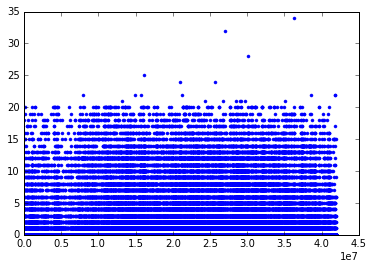

In [10]:
x, y = zip(*((pos, error[1][1]) for pos, error in mendel_results.items()))
plt.plot(x, y, '.')

In [11]:
window_size = 250000
max_pos = max(mendel_results.keys())
num_bins = max_pos // window_size + 1
wins = [[0, 0] for x in range(num_bins)]
for pos in mendel_results:
    wins[pos // window_size][0] += 1
for pos, err in mendel_results.items():
    if err[1][1] == 0:
        continue
    wins[pos // window_size][1] += 1
frac_errors = [errs / poses for poses, errs in wins]

0.14015125837393716

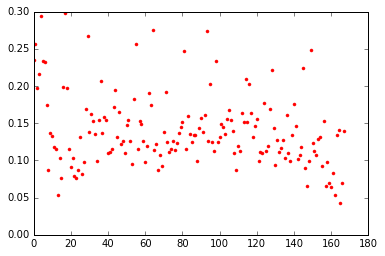

In [12]:
plt.plot(frac_errors, '.', c='r')
sum(frac_errors)/len(frac_errors)

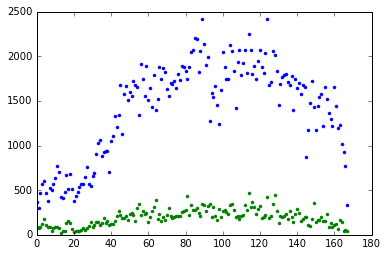

In [13]:
plt.plot([poses for poses in wins], '.')

In [14]:
#errors by annotation type

In [15]:
for entry in store_3L.get_node('/3L/variants'):
    print(entry)

/3L/variants/AC (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/AF (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/ALT (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/AN (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/ANN (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/Accessible (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/BaseCounts (EArray(2501730, 4), shuffle, zlib(1)) ''
/3L/variants/BaseQRankSum (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/CHROM (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/ClippingRankSum (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/Coverage (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/CoverageMQ0 (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/DP (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/DS (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/Dels (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/FILTER_LowQual (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/FILTER_PASS (EAr

In [113]:
annotations = ['AC', 'AF', 'AN', 'Coverage', 'DP', 'HRun', 'HaplotypeScore', 'InbreedingCoeff',
              'MLEAC', 'MQ', 'MQRankSum', 'MQ0',
               'QD', 'QUAL', 'POS', 'FS', 'ReadPosRankSum']

In [114]:
def get_train(annotations, return_scaler=False, normalize=True, scale=True):
    train_X = []
    train_Y = []
    scaler = preprocessing.StandardScaler()
    #This is silly (memory-wise)
    annot_dict = {}
    for annotation in annotations:
        annot_dict[annotation] = store_3L.get_node('/3L/variants/%s' % annotation).read()

    for i, pos in enumerate(poses):
        try:
            if pos not in mendel_results:
                continue
        except IndexError:
            continue
        #if pos not in has_errors:
        #    # We throw away 90% of good positions
        #    if random.randint(0, 100) > 10:
        #        continue
        my_entry = []
        for annotation in annotations:
            my_entry.append(annot_dict[annotation][i])
        train_X.append(my_entry)
        train_Y.append(0 if pos in has_errors else 1)

    #train_pre = preprocessing.normalize(preprocessing.scale(train_X))
    if normalize:
        pre_pre = preprocessing.normalize(train_X)
    else:
        pre_pre = train_X
    if scale:
        train_pre = scaler.fit_transform(pre_pre)
    else:
        train_pre = pre_pre
    #train_pre = preprocessing.scale(train_X)
    train_pre = pd.DataFrame(train_pre, columns=annotations)
    train_pre['OK'] = pd.Series(train_Y, index=train_pre.index)
    if return_scaler:
        return train_pre, scaler
    else:
        return train_pre

In [115]:
train_raw = get_train(annotations, normalize=False, scale=False)

In [116]:
train_pre = get_train(annotations)

In [117]:
train_no_norm = get_train(annotations, normalize=False)

## Exploratory analysis

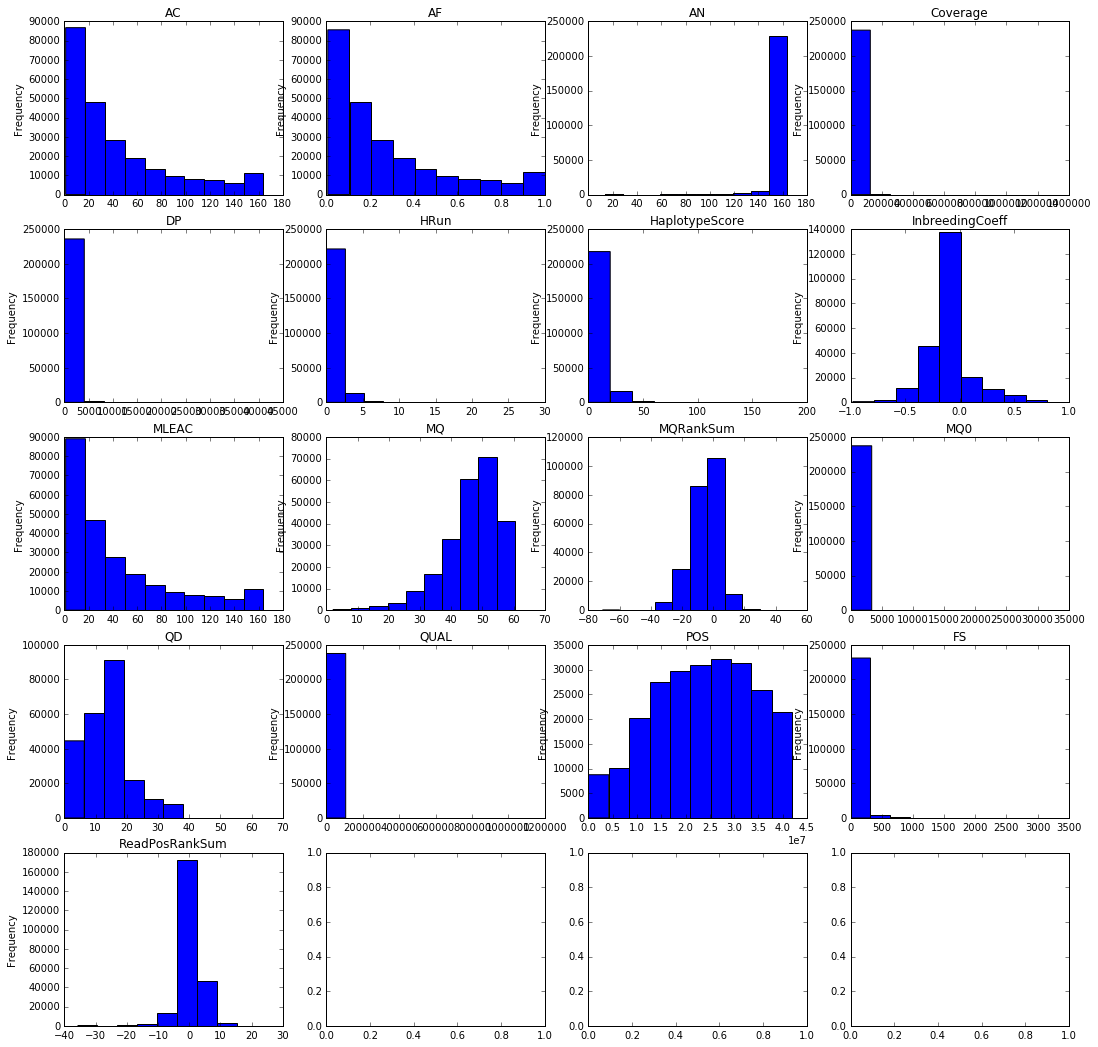

In [119]:
ncols = 4
fig, axs = plt.subplots(5, ncols, figsize=(18, 18), squeeze=False)
row = 0
col = 0
for annotation in annotations:
    train_raw[annotation].plot.hist(ax=axs[row, col])
    axs[row, col].set_title(annotation)
    col += 1
    if col == ncols:
        col = 0
        row += 1

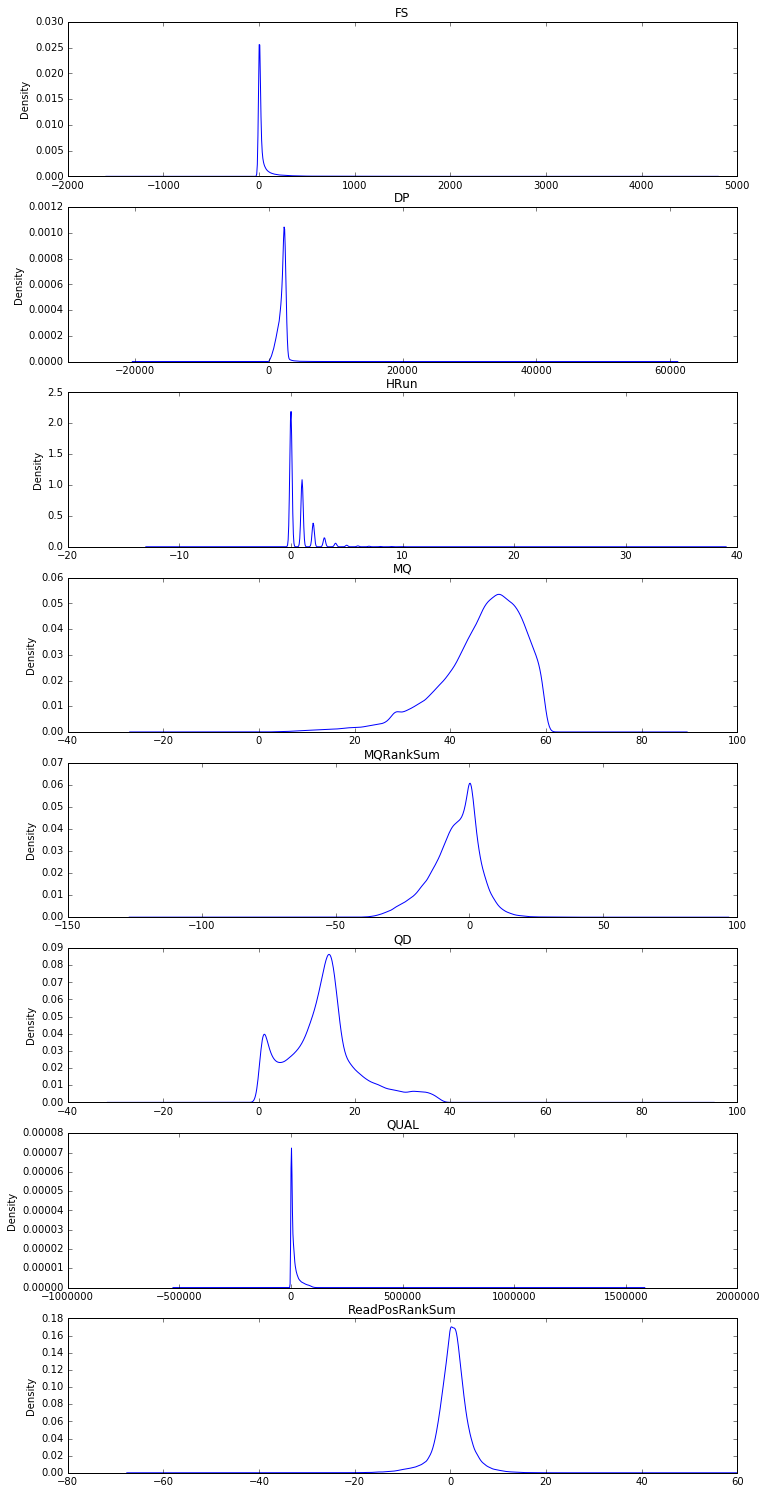

In [120]:
my_annotations = ['FS', 'DP', 'HRun', 'MQ', 'MQRankSum',
               'QD', 'QUAL', 'ReadPosRankSum']
#my_annotations = ['FS', 'DP', 'MQ', 'QD', 'QUAL', 'MQ0']
fig, axs = plt.subplots(len(my_annotations), figsize=(12, 26))
for i, annotation in enumerate(my_annotations):
    train_raw[annotation].plot.kde(ax=axs[i])
    axs[i].set_title(annotation)

(0, 60)

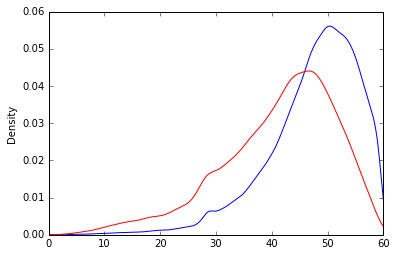

In [121]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['MQ'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['MQ'].plot.kde(ax=ax, c='r')
ax.set_xlim(0, 60)


(-100, 200)

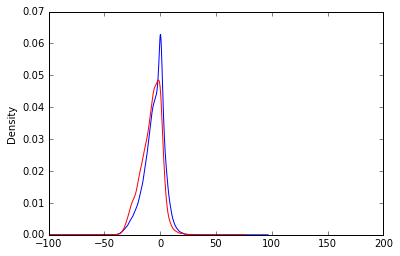

In [122]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['MQRankSum'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['MQRankSum'].plot.kde(ax=ax, c='r')
ax.set_xlim(-100, 200)

(0, 40)

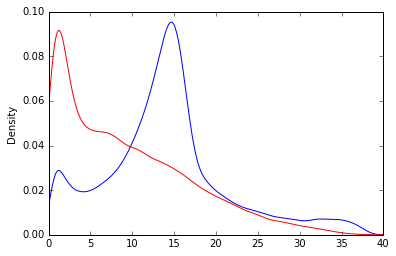

In [123]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['QD'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['QD'].plot.kde(ax=ax, c='r')
ax.set_xlim(0, 40)

(150, 175)

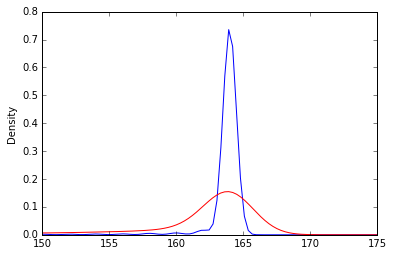

In [124]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['AN'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['AN'].plot.kde(ax=ax,c='r')
ax.set_xlim(150, 175)

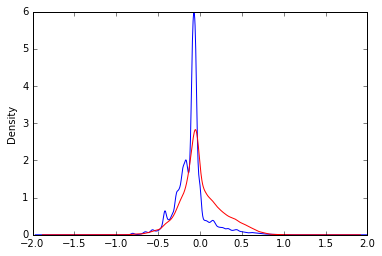

In [125]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['InbreedingCoeff'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['InbreedingCoeff'].plot.kde(ax=ax,c='r')
#ax.set_xlim(150, 175)

(0, 200)

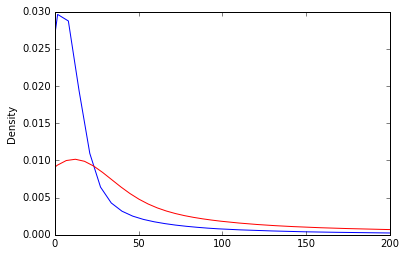

In [126]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['FS'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['FS'].plot.kde(ax=ax,c='r')
ax.set_xlim(0, 200)

(0, 5000)

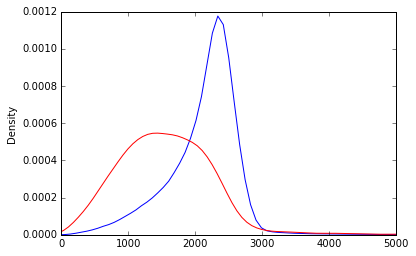

In [127]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['DP'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['DP'].plot.kde(ax=ax,c='r')
ax.set_xlim(0, 5000)

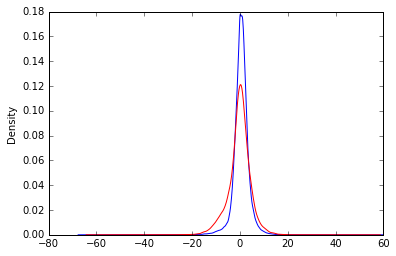

In [128]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['ReadPosRankSum'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['ReadPosRankSum'].plot.kde(ax=ax,c='r')
#ax.set_xlim(0, 5000)

In [129]:
def filter_hard(snp, qd=5):
    if snp['DP'] < 1500 or snp['QD'] < qd or snp['MQ0'] < -50 or snp['MQ0'] > 100:
        return True
    return False

In [130]:
def quantify_filter(qd=5):
    snps_passed = 0
    snps_failed = 0
    good_snps_filtered = 0
    bad_snps_approved = 0
    for id_, snp in train_raw.iterrows():
        filtered_out = filter_hard(snp, qd)
        if filtered_out:
            snps_failed += 1
            if snp['OK'] == 1:
                good_snps_filtered += 1
        else:
            snps_passed += 1
            if snp['OK'] == 0:
                bad_snps_approved += 1
    return snps_passed, snps_failed, good_snps_filtered, bad_snps_approved, bad_snps_approved / snps_passed

print(quantify_filter())
print(quantify_filter(10))

(166990, 70633, 46016, 8187, 0.04902688783759507)
(143420, 94203, 66765, 5366, 0.03741458652907544)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa386bd97f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa39c2af780>]], dtype=object)

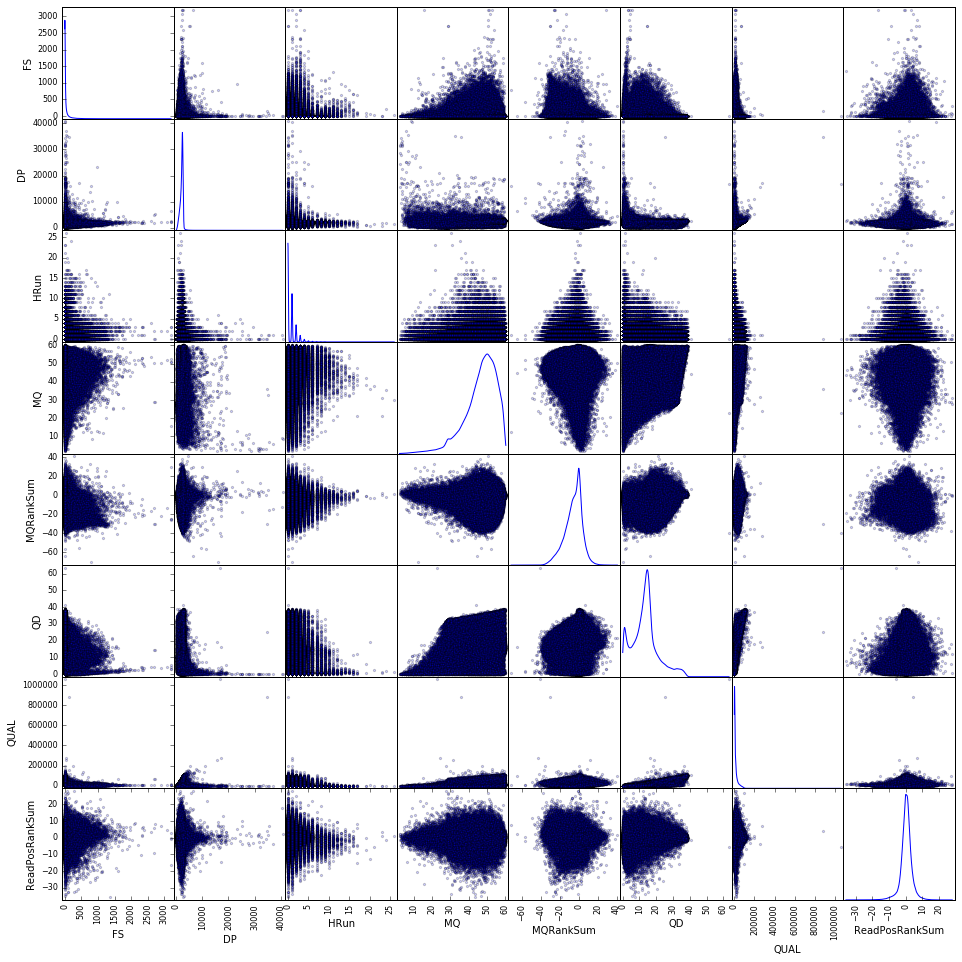

In [131]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(train_raw[my_annotations], alpha=0.2, figsize=(16, 16), diagonal='kde')


(0, 3000)

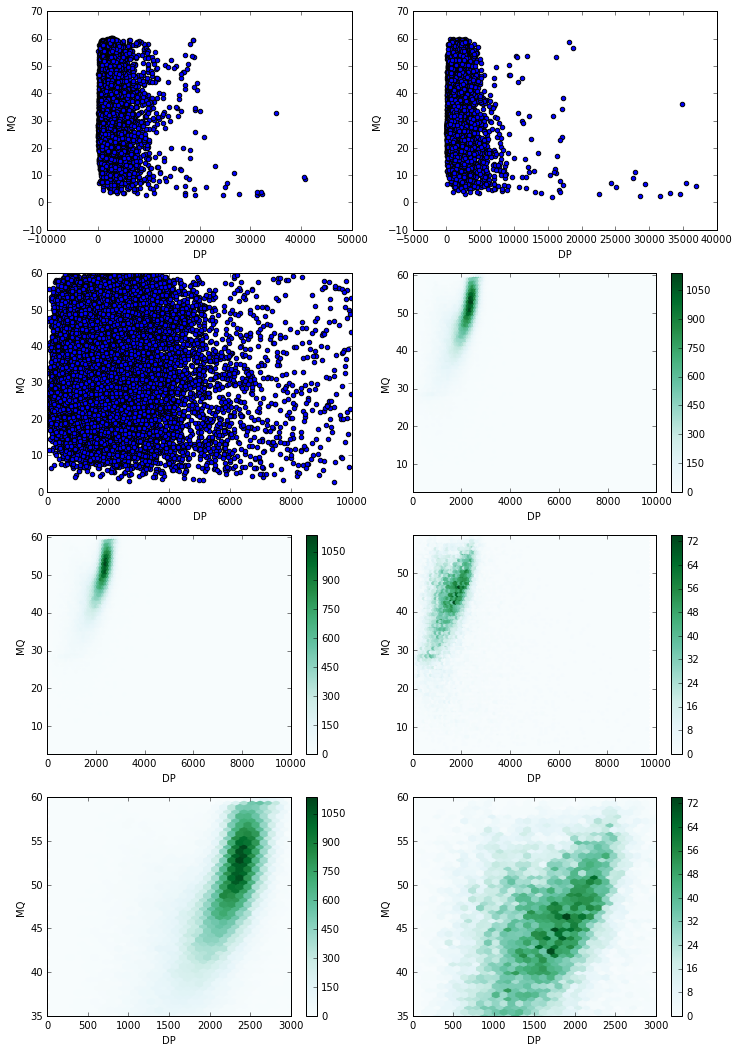

In [132]:
fix, axs = plt.subplots(4, 2, figsize=(12, 18), squeeze=False)

train_raw[train_raw['OK'] == 1].plot.scatter(x='DP', y='MQ', ax=axs[0, 0])
train_raw[train_raw['OK'] == 0].plot.scatter(x='DP', y='MQ', ax=axs[0, 1])


curb_dp = train_raw[train_raw['DP'] < 10000]

curb_dp.plot.scatter(x='DP', y='MQ', ax=axs[1, 0])
axs[1, 0].set_xlim(0, 10000)
axs[1, 0].set_ylim(0, 60)
curb_dp.plot.hexbin(x='DP', y='MQ', ax=axs[1, 1])

curb_dp[curb_dp['OK'] == 1].plot.hexbin(x='DP', y='MQ', ax=axs[2, 0])
axs[2, 0].set_xlim(0, 10000)
curb_dp[curb_dp['OK'] == 0].plot.hexbin(x='DP', y='MQ', ax=axs[2, 1])
axs[2, 1].set_xlim(0, 10000)

curb_dp[curb_dp['OK'] == 1].plot.hexbin(x='DP', y='MQ', ax=axs[3, 0])
axs[3, 0].set_ylim(35, 60)
axs[3, 0].set_xlim(0, 3000)

curb_dp[curb_dp['OK'] == 0].plot.hexbin(x='DP', y='MQ', ax=axs[3, 1])
axs[3, 1].set_ylim(35, 60)
axs[3, 1].set_xlim(0, 3000)


In [133]:
def get_tree(train, annotations):
    tree_clf = tree.DecisionTreeClassifier()
    my_tree = tree_clf.fit(train_pre[annotations].as_matrix(), train['OK'].as_matrix())
    dot_data = StringIO()
    tree.export_graphviz(my_tree, out_file=dot_data, max_depth=4,
                         feature_names=annotations, filled=True)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    img = Image(graph.create_png(prog=['dot', '-Tdot', '-s10', '-Gsize=14,30', '-Gdpi=200']))
    return my_tree, img

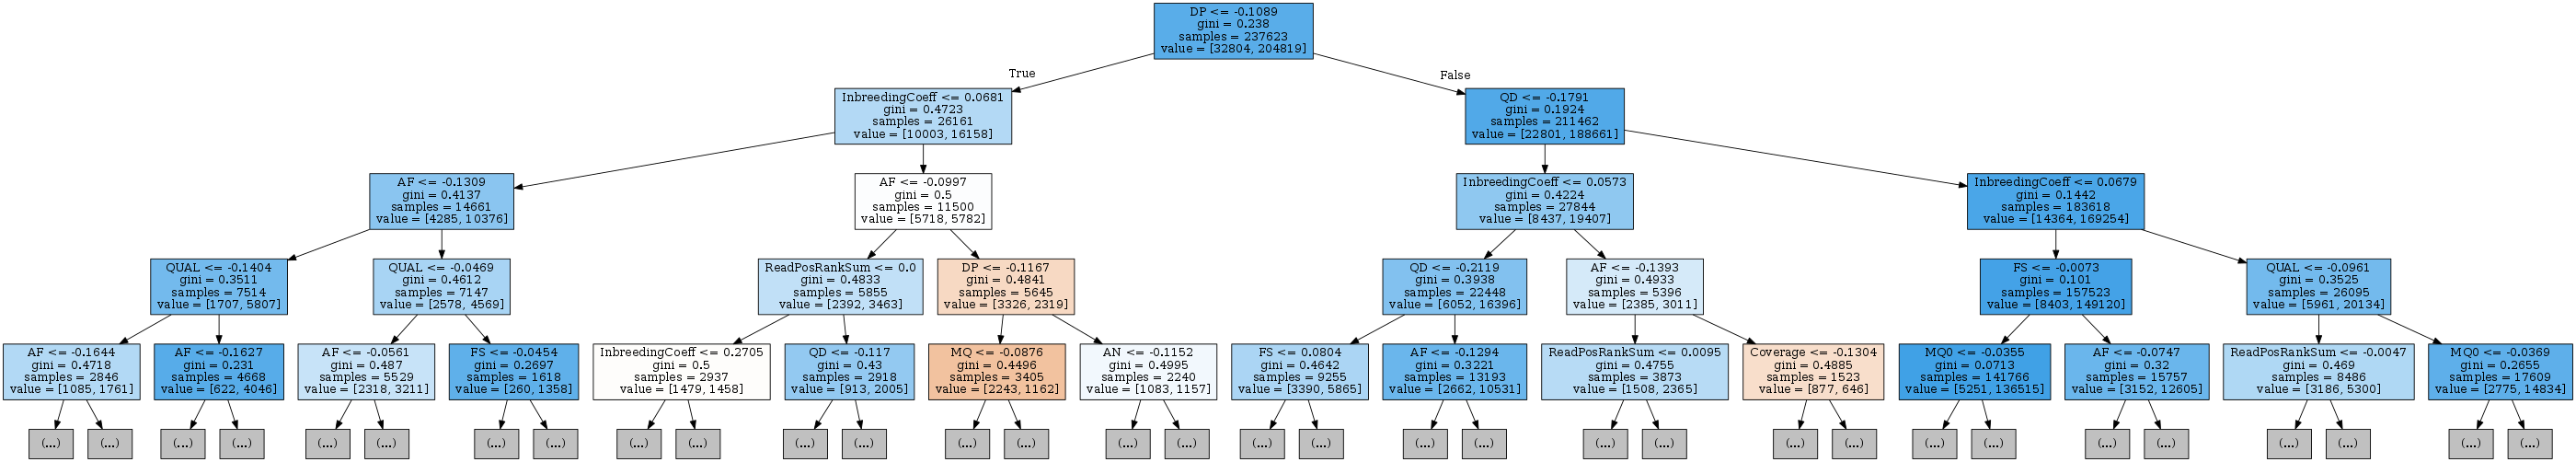

In [216]:
my_tree, img = get_tree(train_pre, annotations)
img

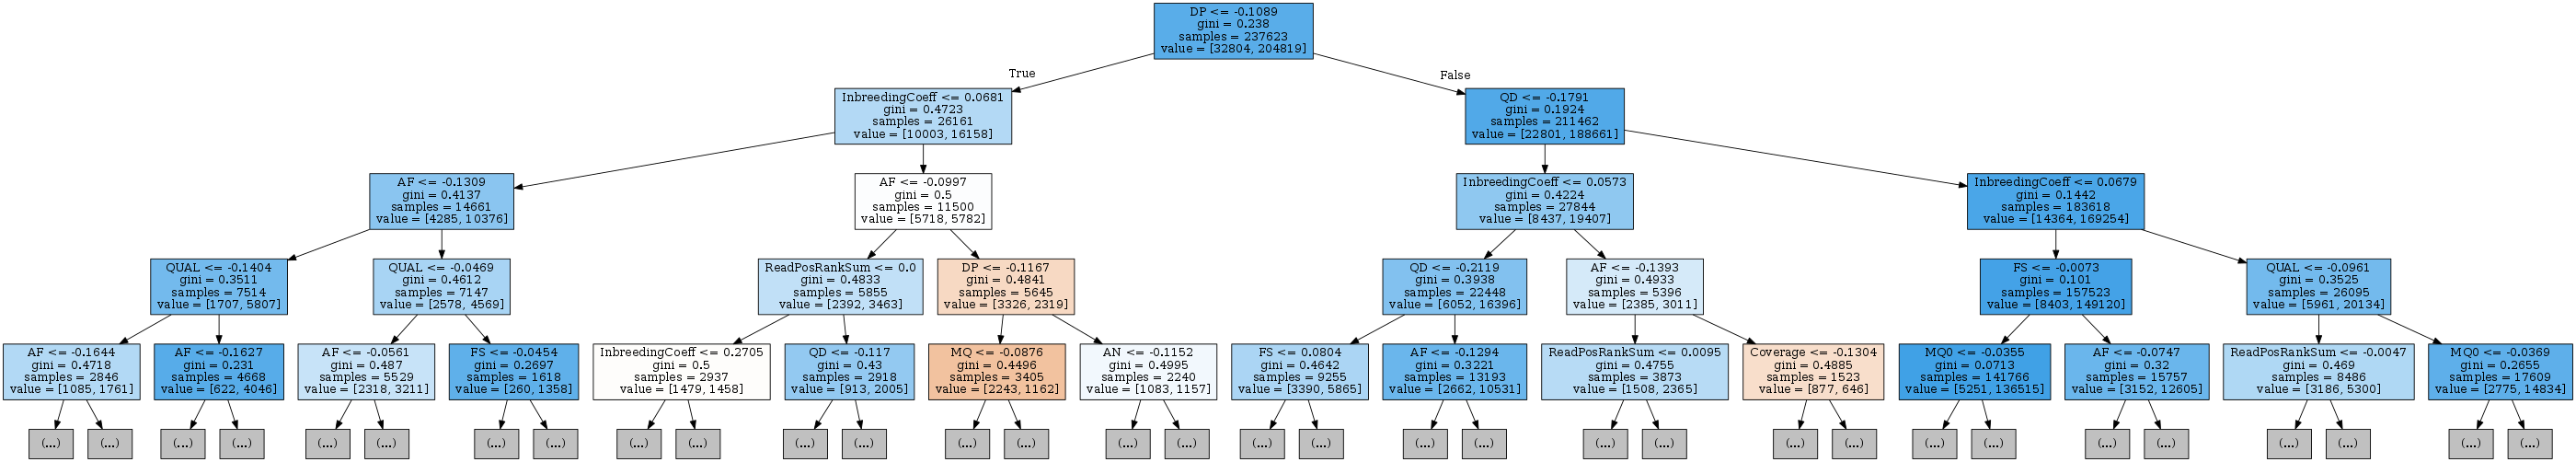

In [217]:
my_tree_no, img = get_tree(train_no_norm, annotations)
img

## Random forest

In [136]:
forest_clf = RandomForestClassifier()
my_forest = forest_clf.fit(train_pre[annotations], train_pre['OK'])

In [137]:
for feat, imp in zip(annotations, my_forest.feature_importances_):
    print(feat, imp)

AC 0.0522188970337
AF 0.0600552954702
AN 0.049498096579
Coverage 0.077095368402
DP 0.0704420702505
HRun 0.0249402892847
HaplotypeScore 0.0465518577886
InbreedingCoeff 0.0898460499392
MLEAC 0.0526073773251
MQ 0.0493679344098
MQRankSum 0.0529503836764
MQ0 0.0359949203032
QD 0.0784971246951
QUAL 0.0888019546382
POS 0.0462351874247
FS 0.0630171187213
ReadPosRankSum 0.0618800740581


## PCA

In [211]:
ssize = 500
#train_ok = train_pre[train_pre['OK'] == 1].sample(ssize)
#train_err = train_pre[train_pre['OK'] == 0].sample(ssize)
#train_ok = train_raw[train_raw['OK'] == 1].sample(ssize)
#train_err = train_raw[train_raw['OK'] == 0].sample(ssize)
train_ok = train_no_norm[train_no_norm['OK'] == 1].sample(ssize)
train_err = train_no_norm[train_no_norm['OK'] == 0].sample(ssize)
both_train = pd.concat([train_ok, train_err])
both_pca = PCA(n_components=6)
both_pca.fit(both_train[annotations])
both_trans = both_pca.transform(both_train[annotations])
both_trans = pd.DataFrame(both_trans, columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6'], index=both_train.index)
both_trans = pd.concat([both_train, pd.DataFrame(both_trans)], axis=1)
both_trans.shape

(1000, 24)

In [212]:
def plot_pca(trans, annotations, c1, c2):
    #print(trans['OK'])
    fig, axs = plt.subplots(5, 4, squeeze=False, sharex=True, sharey=True, figsize=(18, 18))
    axs[0, 0].scatter(trans[c1].as_matrix(), trans[c2].as_matrix(), edgecolors='face', s=10)
    axs[0, 0].set_title('PCA: Basic')
    
    trans_ok = trans[trans['OK'] == 1]
    axs[0, 1].scatter(trans_ok[c1].as_matrix(), trans_ok[c2].as_matrix(), edgecolors='face', s=10)
    axs[0, 1].set_title('OK')

    trans_err = trans[trans['OK'] == 0]
    axs[0, 2].scatter(trans_err[c1].as_matrix(), trans_err[c2].as_matrix(), edgecolors='face', s=10)
    axs[0, 2].set_title('Error')
    
    row = 0
    col = 3

    for annotation in annotations:
        axs[row, col].scatter(trans[c1].as_matrix(), trans[c2].as_matrix(),
                              edgecolors='face', c=trans[annotation].as_matrix())
        axs[row, col].set_title(annotation)
        if col == 3:
            row += 1
            col = 0
        else:
            col += 1
    return fig

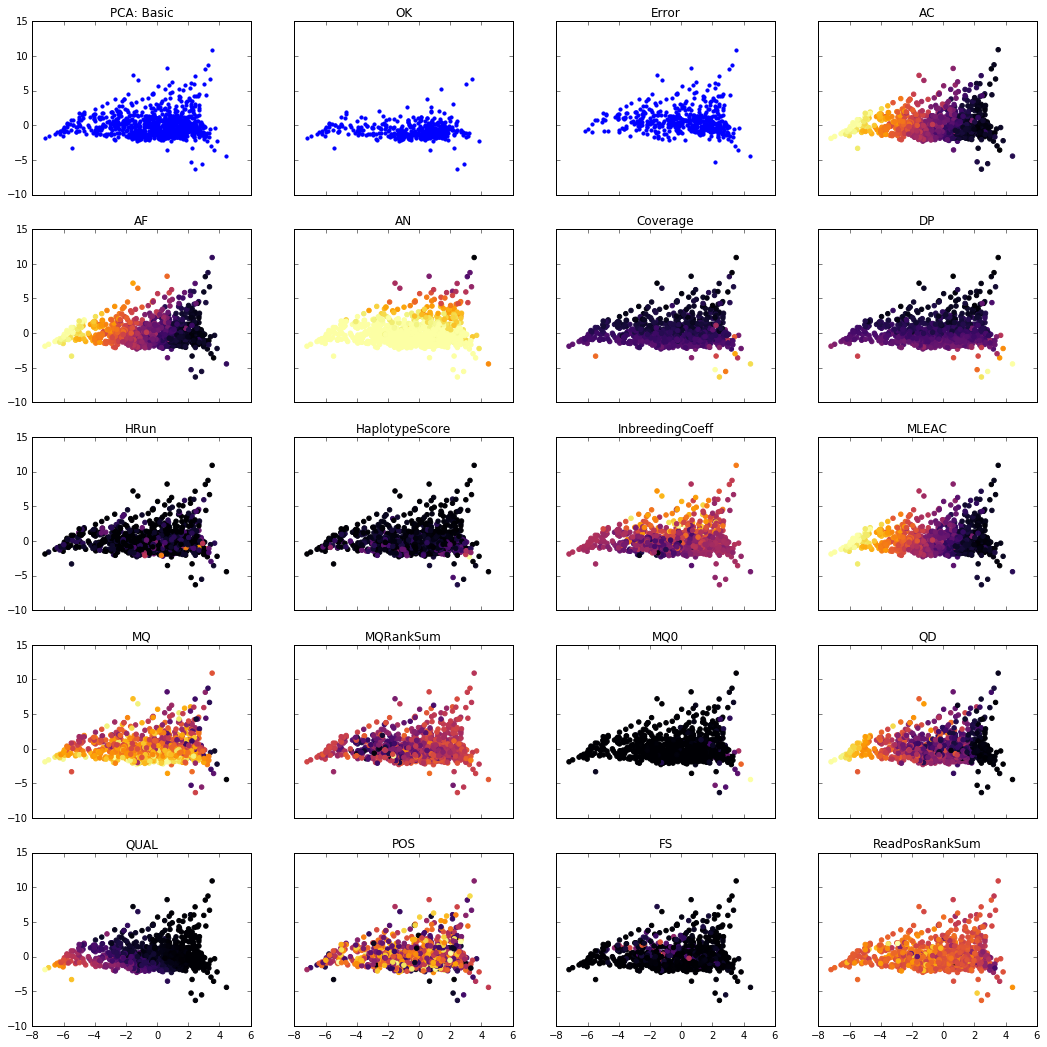

In [213]:
plt.rcParams['image.cmap'] = 'inferno'
plot_pca(both_trans, annotations, 'pc1', 'pc2')
pass

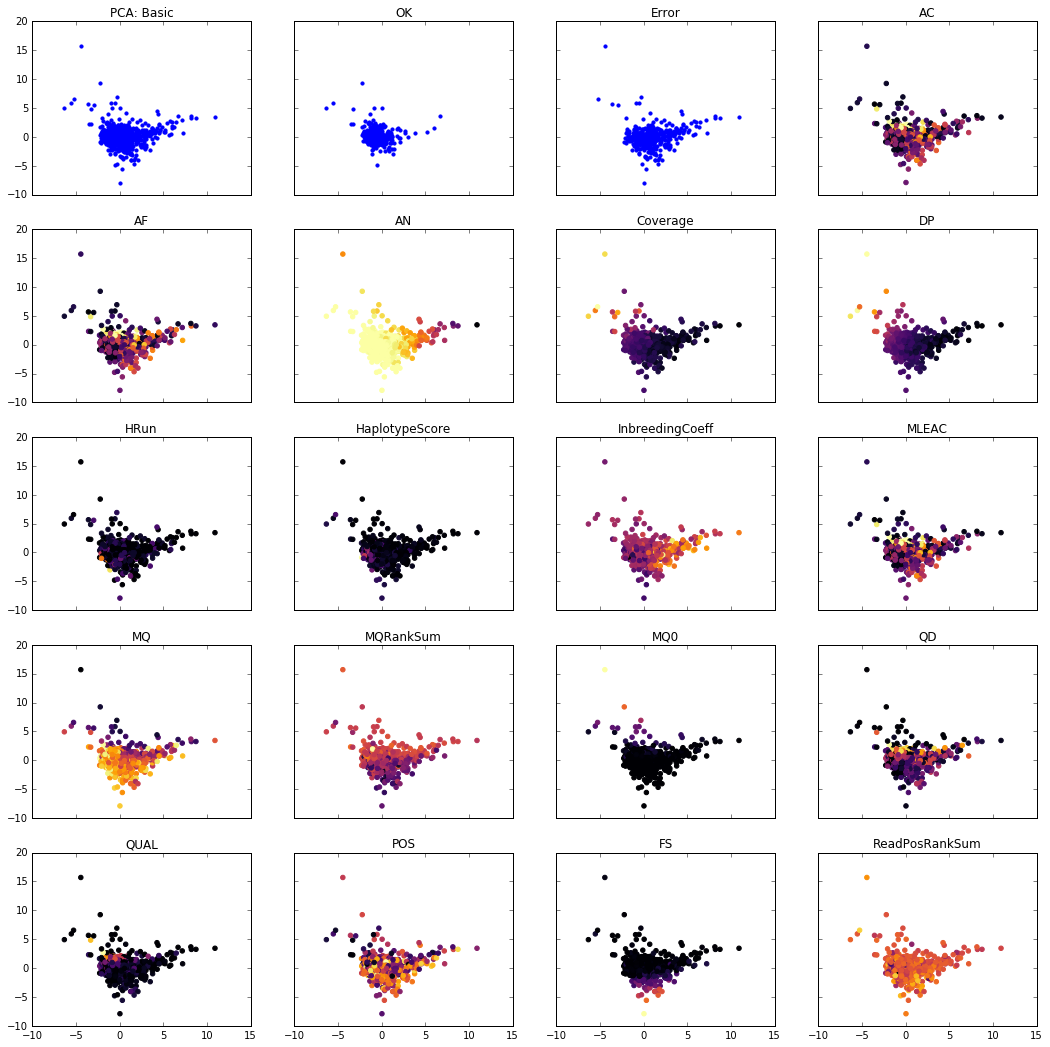

In [214]:
plot_pca(both_trans, annotations, 'pc2', 'pc3')
pass

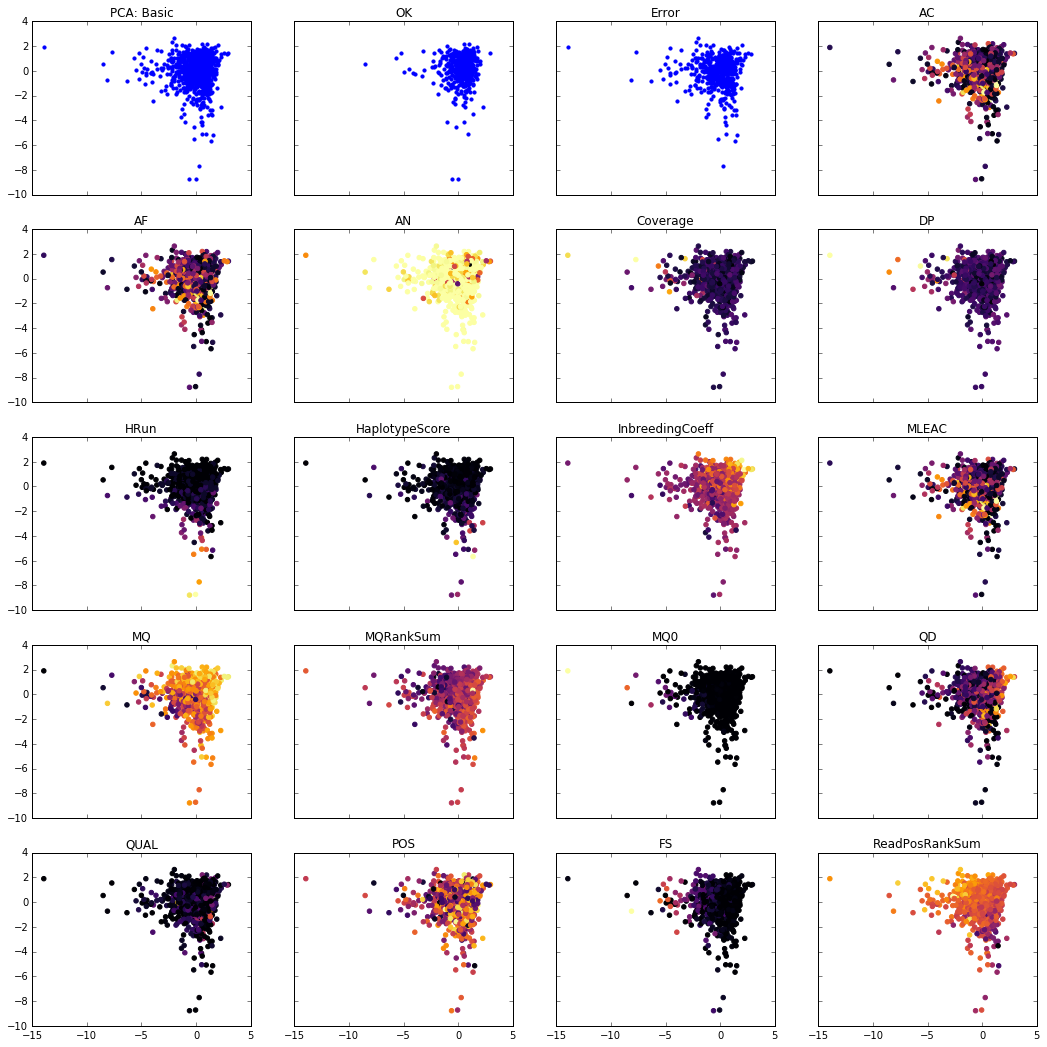

In [215]:
plot_pca(both_trans, annotations, 'pc4', 'pc5')
pass

## Covariance

In [142]:
train_pre[annotations].cov()

,AC,AF,AN,Coverage,DP,HRun,HaplotypeScore,InbreedingCoeff,MLEAC,MQ,MQRankSum,MQ0,QD,QUAL,POS,FS,ReadPosRankSum
AC,1.000004,0.996198,0.642745,0.514642,0.531870,0.317891,0.310659,-0.176143,0.998224,0.610050,-0.376801,0.269999,0.802073,0.747410,-0.494674,0.279744,-0.067276
AF,0.996198,1.000004,0.645322,0.513741,0.523997,0.323114,0.308829,-0.152497,0.993564,0.611424,-0.373407,0.274426,0.796670,0.727213,-0.488170,0.275969,-0.079001
AN,0.642745,0.645322,1.000004,0.781068,0.865180,0.525497,0.489448,-0.170446,0.620322,0.960883,-0.525613,0.438506,0.673535,0.348066,-0.556527,0.307275,-0.184900
Coverage,0.514642,0.513741,0.781068,1.000004,0.915061,0.411629,0.500908,-0.324000,0.503992,0.709359,-0.339227,0.559542,0.484199,0.323619,-0.778561,0.280940,-0.004429
DP,0.531870,0.523997,0.865180,0.915061,1.000004,0.443203,0.504872,-0.344612,0.518160,0.806832,-0.429481,0.558285,0.521819,0.360712,-0.733323,0.301690,-0.049105
HRun,0.317891,0.323114,0.525497,0.411629,0.443203,1.000004,0.327847,-0.181206,0.309972,0.507300,-0.293376,0.226574,0.304892,0.165710,-0.254421,0.184881,-0.118949
HaplotypeScore,0.310659,0.308829,0.489448,0.500908,0.504872,0.327847,1.000004,-0.219884,0.301946,0.461950,-0.288026,0.208860,0.252788,0.154975,-0.323667,0.269619,-0.031828
InbreedingCoeff,-0.176143,-0.152497,-0.170446,-0.324000,-0.344612,-0.181206,-0.219884,1.000004,-0.200065,-0.124745,0.082102,-0.223800,-0.120714,-0.315271,0.374685,-0.260802,-0.165593
MLEAC,0.998224,0.993564,0.620322,0.503992,0.518160,0.309972,0.301946,-0.200065,1.000004,0.588530,-0.353902,0.259400,0.805962,0.759642,-0.492238,0.273623,-0.047096
MQ,0.610050,0.611424,0.960883,0.709359,0.806832,0.507300,0.461950,-0.124745,0.588530,1.000004,-0.525991,0.232147,0.723763,0.376014,-0.498886,0.267870,-0.215832


## Re-analyze

In [148]:
reduced_annotations = ['DP', 'HRun', 'MQRankSum', 'MQ0', 'QD', 'FS', 'ReadPosRankSum']

In [149]:
train_reduced = get_train(reduced_annotations)

In [150]:
train_reduced_no_norm = get_train(reduced_annotations, normalize=False)

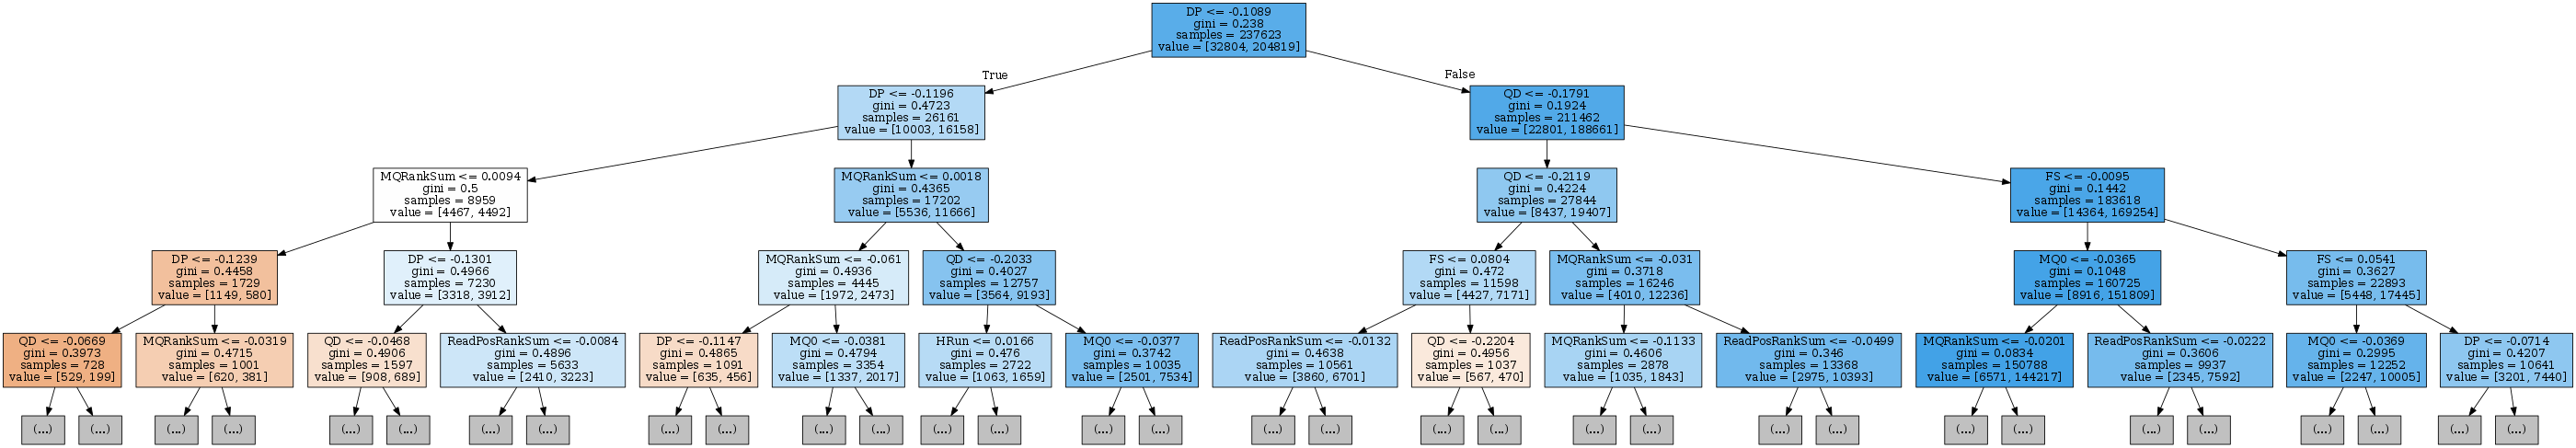

In [151]:
tree_reduced, img_reduced = get_tree(train_reduced, reduced_annotations)
img_reduced

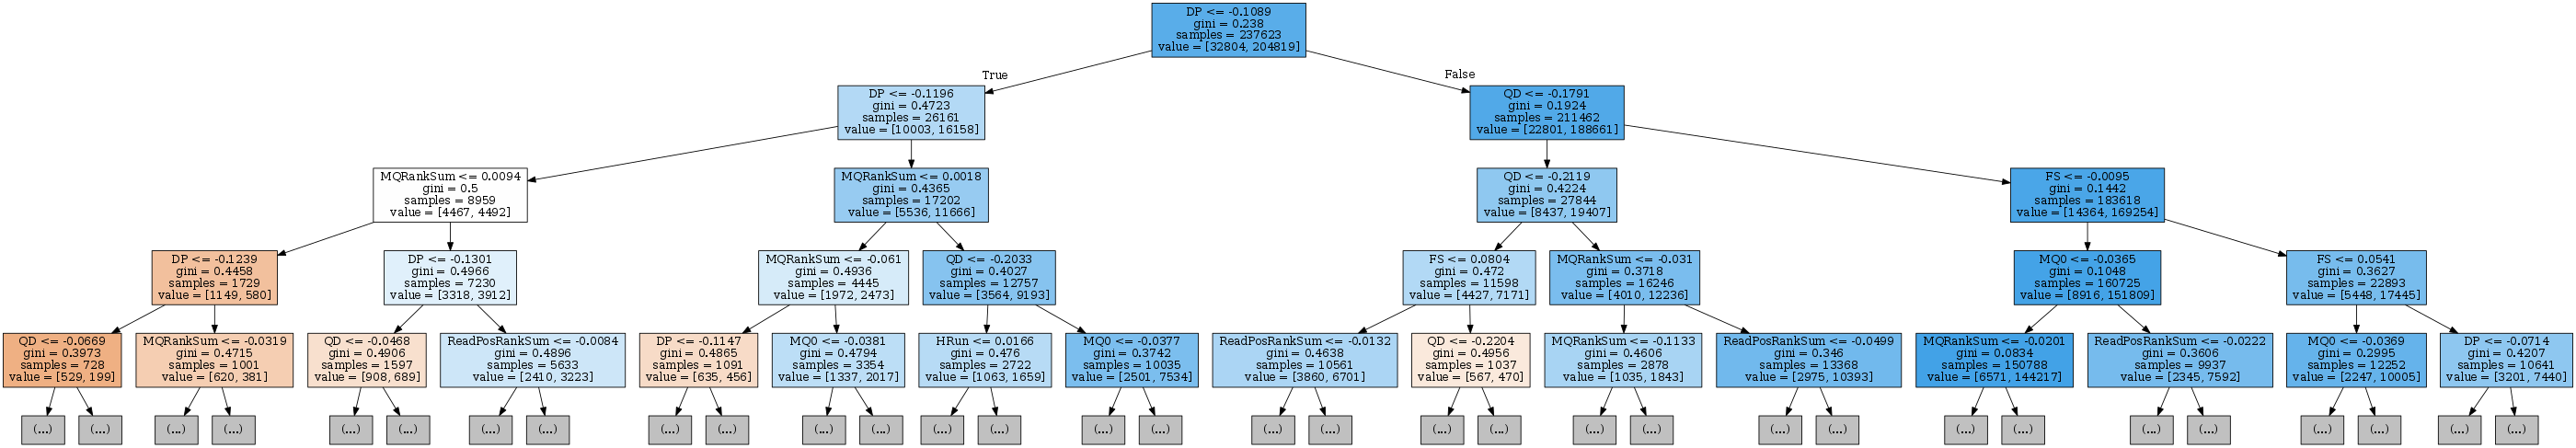

In [152]:
tree_reduced_no, img_reduced = get_tree(train_reduced_no_norm, reduced_annotations)
img_reduced

In [153]:
forest_reduced_clf = RandomForestClassifier()
forest_reduced = forest_clf.fit(train_reduced[reduced_annotations], train_reduced['OK'])

In [154]:
for feat, imp in zip(reduced_annotations, forest_reduced.feature_importances_):
    print(feat, imp)

DP 0.187475527606
HRun 0.0765346001565
MQRankSum 0.172284724681
MQ0 0.0660615221628
QD 0.181958510337
FS 0.149529829087
ReadPosRankSum 0.16615528597


In [155]:
train_reduced[reduced_annotations].cov()

,DP,HRun,MQRankSum,MQ0,QD,FS,ReadPosRankSum
DP,1.000004,-0.072824,0.099474,-0.676520,-0.045558,-0.579218,-0.025167
HRun,-0.072824,1.000004,-0.048347,0.044375,0.232203,0.112730,-0.037720
MQRankSum,0.099474,-0.048347,1.000004,0.082536,-0.022555,-0.346924,-0.165328
MQ0,-0.676520,0.044375,0.082536,1.000004,-0.059938,-0.009987,-0.030831
QD,-0.045558,0.232203,-0.022555,-0.059938,1.000004,0.088838,0.054139
FS,-0.579218,0.112730,-0.346924,-0.009987,0.088838,1.000004,0.085732
ReadPosRankSum,-0.025167,-0.037720,-0.165328,-0.030831,0.054139,0.085732,1.000004


In [156]:
ssize = 10000
train_reduced_ok = train_reduced[train_reduced['OK'] == 1].sample(ssize)
train_reduced_err = train_reduced[train_reduced['OK'] == 0].sample(ssize)
both_train_reduced = pd.concat([train_reduced_ok, train_reduced_err])
both_pca_reduced = PCA(n_components=4)
both_pca_reduced.fit(both_train_reduced[reduced_annotations])
both_trans_reduced = both_pca_reduced.transform(both_train_reduced[reduced_annotations])
both_trans_reduced = pd.DataFrame(both_trans_reduced, columns=['pc1', 'pc2', 'pc3', 'pc4'], index=both_train_reduced.index)
both_trans_reduced = pd.concat([both_train_reduced, pd.DataFrame(both_trans_reduced)], axis=1)
both_trans_reduced.shape

(20000, 12)

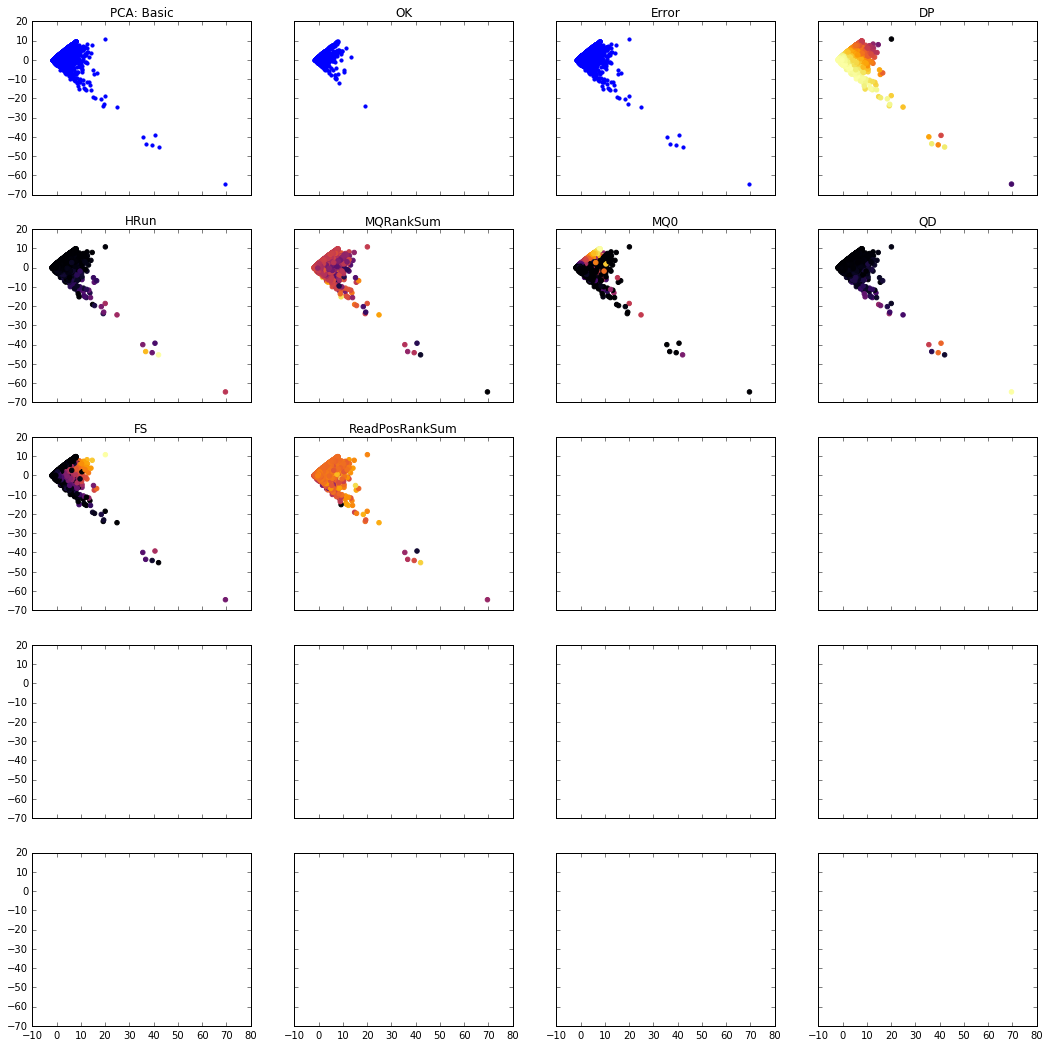

In [157]:
plot_pca(both_trans_reduced, reduced_annotations, 'pc1', 'pc2')
pass

## Regressor

In [158]:
both_train_reduced_again = pd.concat([train_reduced_ok, train_reduced_err])
train_reduced_with_scale, scaler = get_train(reduced_annotations, True)

In [167]:
ssize = 10000

train_reduced_ok_sc = train_reduced_with_scale[train_reduced_with_scale['OK'] == 1].sample(ssize)
train_reduced_err_sc = train_reduced_with_scale[train_reduced_with_scale['OK'] == 0].sample(ssize)

both_train_reduced_sc = pd.concat([train_reduced_ok_sc, train_reduced_err_sc])

In [181]:
clf = linear_model.LogisticRegression()
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf = linear_model.SGDClassifier()
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(n_estimators=10, max_depth=10)
clf.fit(both_train_reduced_sc[reduced_annotations], np.ravel(both_train_reduced_sc['OK']))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [182]:
clf.score(both_train_reduced_sc[reduced_annotations], np.ravel(both_train_reduced_sc['OK']))


0.80589999999999995

In [183]:
#both_train_reduced_sc[reduced_annotations].columns, np.transpose(clf.coef_)

In [184]:
my_parents = parents[0]
ofs_mo = samples.index(my_parents[0])
ofs_fa = samples.index(my_parents[1])
ofs_start, ofs_end = get_offspring_range(my_parents, parents, samples)

annot_dict = {}
for annotation in reduced_annotations:
    annot_dict[annotation] = store_3L.get_node('/3L/variants/%s' % annotation).read()


i = 0
test_results = collections.OrderedDict()
all_entries = []
all_Y = []
for i, pos in enumerate(poses):
    genotype = genotypes[i]
    mo_alleles = genotype[ofs_mo,:]
    fa_alleles = genotype[ofs_fa,:]
    ofs_alleles = genotype[ofs_start:ofs_end,:]
    my_entry = []
    for annotation in reduced_annotations:
        my_entry.append(annot_dict[annotation][i])
    errors = compute_medelian_errors([mo_alleles, fa_alleles], ofs_alleles)
    if errors is None:
        cnt = None
    else:
        total, cnt, cnt_mo, cnt_fa = errors
        all_Y.append(0 if cnt > 0 else 1)
        all_entries.append(my_entry)
    i += 1
    if i == 1000:
        break

ready_data = scaler.transform(preprocessing.normalize(all_entries))
prediction = clf.predict(ready_data)
test_results[pos] = cnt, prediction[0]
del annot_dict

In [185]:
clf.score(ready_data, all_Y)

0.51902173913043481

In [186]:
num_errors = 0
for cnt, prediction in zip(all_Y, all_entries):
    #print(cnt, prediction)
    if cnt > 0 and prediction[0] == 0:
        num_errors += 1 

In [187]:
store_3L

File(filename=../raw/crosses-3L.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/3L (Group) ''
/3L/samples (Array(80,)) ''
  atom := StringAtom(itemsize=8, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None
/3L/calldata (Group) ''
/3L/calldata/AD (EArray(2501730, 80, 2), shuffle, zlib(1)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (3276, 10, 2)
/3L/calldata/DP (EArray(2501730, 80), shuffle, zlib(1)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (6553, 10)
/3L/calldata/GQ (EArray(2501730, 80), shuffle, zlib(1)) ''
  atom := UInt8Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (13107, 10)
/3L/calldata/GT (EArray(2501730, 80), shuffle, zlib(1)

In [226]:
!zcat ../raw/total-3L.vcf.gz|head -95

##fileformat=VCFv4.1
##FILTER=<ID=PASS,Description="All filters passed">
##FILTER=<ID=LowQual,Description="Low quality">
##FORMAT=<ID=AB,Number=1,Type=Float,Description="Allele balance for each het genotype">
##FORMAT=<ID=AD,Number=.,Type=Integer,Description="Allelic depths for the ref and alt alleles in the order listed">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Approximate read depth (reads with MQ=255 or with bad mates are filtered)">
##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=MQ0,Number=1,Type=Integer,Description="Number of Mapping Quality Zero Reads per sample">
##FORMAT=<ID=PL,Number=G,Type=Integer,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
##GATKCommandLine=<ID=SelectVariants,Version=3.3-0-g37228af,Date="Sat Feb 28 09:38:33 GMT 2015",Epoch=1425116313026,CommandLineOptions="analysis_type=SelectVariants input_file